<a href="https://colab.research.google.com/github/Sakshee5/XAI-Assignments/blob/global-explainable-ml/Global_Explanations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global Explanations

1. Partial Dependence Plots (PDP)
2. Individual Conditional Expectation (ICE) Plots
3. Accumulated Local Effects (ALE) PLots

### Dataset Chosen

Auto.csv

The dataset can be used to analyze trends in automobile performance and efficiency. For example, exploring how fuel efficiency correlates with horsepower, weight, and engine displacement or how cars from different origins compare. The reason I chose the dataset is because the feature co-relation and interaction will be easily interpretable since I can compare them with my general knowledge about how these faetures are supposed to interact. Moreover, I am assuming there will be significant co-relation between the input features, so it'll be interesting to see how and where PDP fails and if it's validated by my general knowledge about how fuel efficiency works.

### Data Features and General Knowledge
- mpg (Miles per gallon): Indicates fuel efficiency. Higher values mean better fuel economy. This is our target variable.
- cylinders: Refers to the number of engine cylinders. Typically, more cylinders mean higher power output but lower fuel efficiency.
- displacement: represents the engine's size. Higher displacement often indicates a more powerful engine.
- horsepower: Measures engine power. Higher horsepower indicates a stronger engine.
- weight: The weight of the car in pounds. Heavier cars generally have lower fuel efficiency.
- acceleration: Time in seconds to go from 0 to 60 miles per hour. Lower values mean faster acceleration.
- year: The model year of the car..
- origin: Numerical code for the country of origin.
- name: The name of the car, including the make and model.

### Model Used
Random Forest for Regression Analysis

## Import Required Libraries

In [ ]:
!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

  Cloning https://github.com/MaximeJumelle/ALEPython.git (to revision dev) to /tmp/pip-install-n5j46l7j/alepython_1a9e72e2d76743ba9962242d9c0647bd
  Running command git clone --filter=blob:none --quiet https://github.com/MaximeJumelle/ALEPython.git /tmp/pip-install-n5j46l7j/alepython_1a9e72e2d76743ba9962242d9c0647bd
  Resolved https://github.com/MaximeJumelle/ALEPython.git to commit 286350ab674980a32270db2a0b5ccca1380312a7
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.2 MB/s eta 0:00:00
  Created wheel for alepython: filename=alepython-0.1.dev17+g286350a-py3-none-any.whl size=15139 sha256=e7b5dd1965444c34278188ad3e04da010513c4a154c5b046bb689635d5df2733
  Stored in directory: /tmp/pip-ephem-wheel-cache-ycgnzaq_/wheels/80/2e/91/7f216caef9a7f0c6ce18ee562b6156df43b3a79f69a0c1f3d1
Successfully built alepython


In [ ]:
# Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Models
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# XAI
from alepython import ale_plot
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

# handle warnings
import warnings
warnings.filterwarnings("ignore")

# seeding for reproducability
np.random.seed(1)

In [ ]:
# Download files in the same directory as notebook
import urllib.request
from pathlib import Path
import os
path = Path()

files = {'Auto.csv':'https://storage.googleapis.com/aipi_datasets/Auto.csv'}

# Download each file
for key,value in files.items():
    filename = path/key
    url = value
    # If the file does not already exist in the directory, download it
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url,filename)

def load_data(filename):

    data = pd.read_csv(filename)
    # Remove rows with missing values
    data = data[data['horsepower'] != '?'].copy()
    data['horsepower'] = data['horsepower'].astype(float)
    return data

data = load_data('Auto.csv')
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


To Note: acceleration here is not the car accerelation value but the time taken for it in seconds to go from 0 to 60 miles per hour. So higher the acceleration value in the table, lower the acceleration power of the car.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    int64  
 8   name          392 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB


There are no missing values

In [ ]:
data.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


- Understanding the range of mpg later put into perspective - "how much change" in the target variable will be significant.

For example, Change of 10 for target variable ranging from 0 to 100000 is not significant, but it will be significant in case of mpg.

- The car models are from 70s-80s.

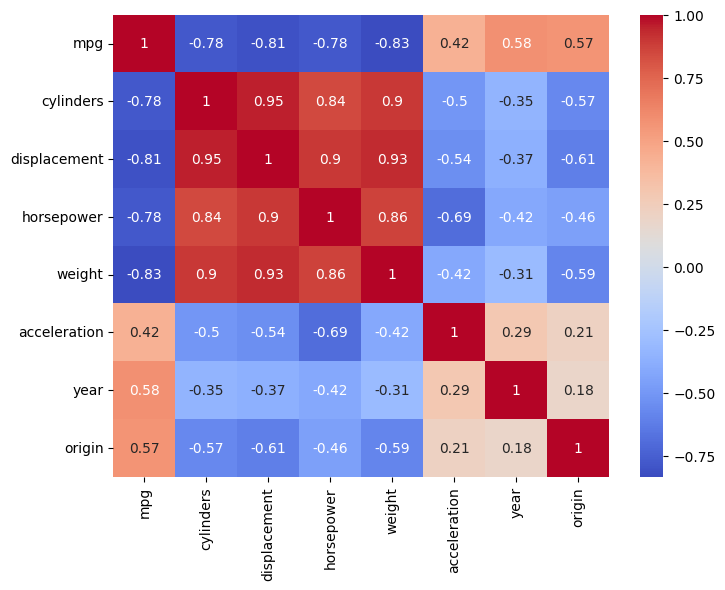

In [ ]:
# plotting a heatmap
corr = data.drop(['name'], axis=1).corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

As expected, there is significant positive and negative co-relation between multiple features.

The target variable mpg is highly negatively co-related with the weight of the car followed by displacement, cylinders and horsepower. This makes sense beacuse heavier (luxury/sports) cars generally have lower fuel efficiency. Higher displacement, cylinders and horsepower indicate higher power output which leads to lower fuel efficiency. Acceleration, year and origin have a positive co-relation with mpg meaning that recent cars/cars from a particular region have better efficiency.

Besides co-relation with the target variable, there is high co-relation between the input features themselves as expected. For example, horsepower and displacement have a strong positive co-relation. Displacement has an even more significant co-relation with the number of cyclinders.

In [ ]:
def prep_data(data, pct):
    X = data.drop(['mpg', 'name'],axis=1)
    y = data['mpg'].astype(float)

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=pct)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = prep_data(data, pct=0.2)

In [ ]:
model = RandomForestRegressor().fit(X_train, y_train)

In [ ]:
features = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin']

# Comparing ICE Plots, Partial Dependence Plot and ALE Plots for each feature

Since there is a high co-relation between the input features, PDP plots will not be reliable since it will not be able to accurately explain interaction between various features. PDP assumes independence among features, which can be misleading in datasets with high multicollinearity. ALE plots would be more suitable to analyze for the chosen dataset.

For each of the cells below, I will plot the following plots in order and provide an interpretaion.
1. ICE PLot
2. PDP
3. ALE Plot

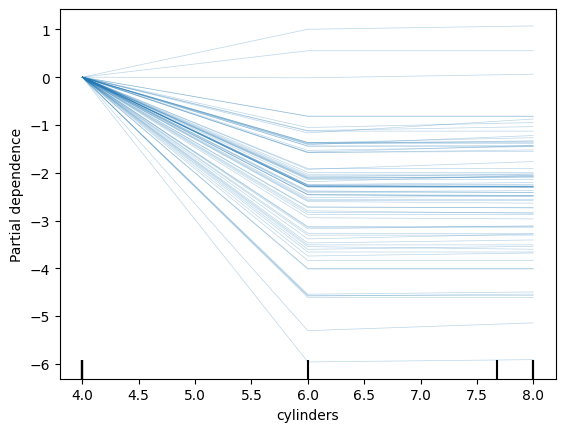

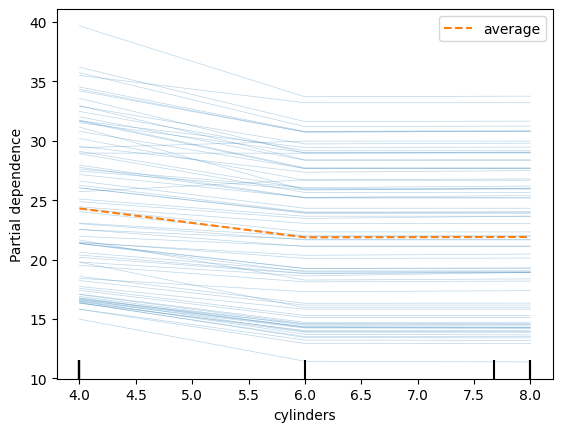

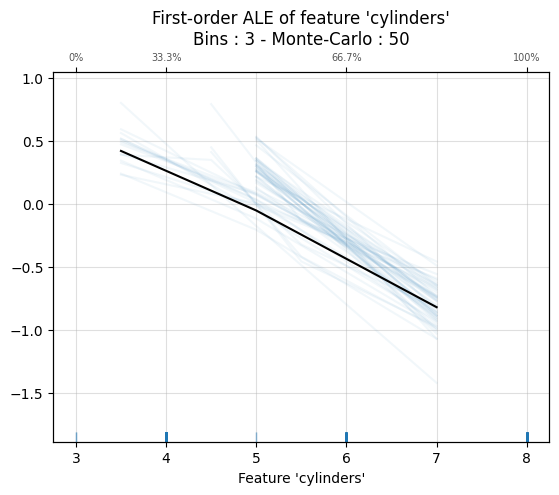

<Axes: title={'center': "First-order ALE of feature 'cylinders'\nBins : 3 - Monte-Carlo : 50"}, xlabel="Feature 'cylinders'">

In [ ]:
PartialDependenceDisplay.from_estimator(model, X_test, [features[0]], kind='individual', centered=True)

# Use PartialDependenceDisplay to display the ICE plot and the PDP overlayed on top
PartialDependenceDisplay.from_estimator(model, X_test, features=[features[0]], kind='both')

ale_plot(model, X_train, features[0], monte_carlo=True)

The ICE plot shows individual lines for each data instance, highlightin and tells how the 'number of cylinders` affects MPG for each specific case. In this case, there is a clear decrease in mpg for cylinders incraesing from 3 to 6 but no change for increase in cylinders afterwards. This is deviating from what we would generally assume that higher the cylinders, lower the mpg.

For the PDP Plot, as the number of cylinders increases, the partial dependence very gradually decreases, indicating lower fuel efficiency.

The ALE plot however, indicates that increasing cylinders generally to decreased MPG, with sharper declines at higher cylinder counts.

Both plots agree on the overall trend and show that as the number of cylinders increases, there is a negative impact on MPG. Although, the PDP shows a very gradual decrease, while the ALE plot shows a more pronounced non-linear relationship with a steeper decline after 5 cylinders.

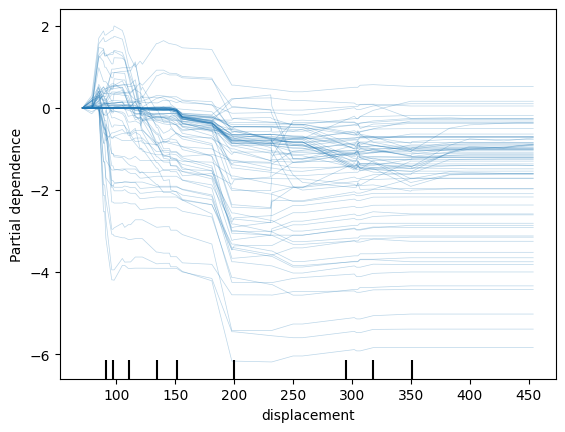

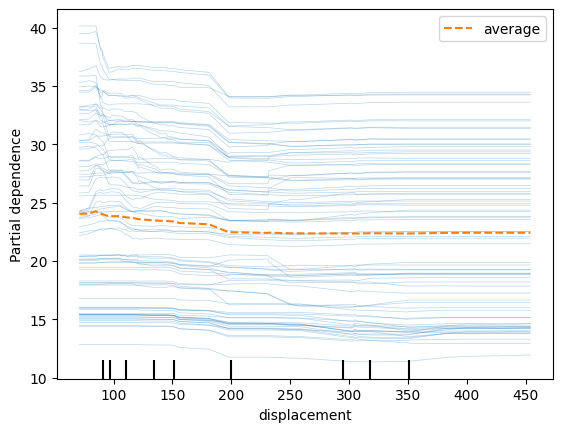

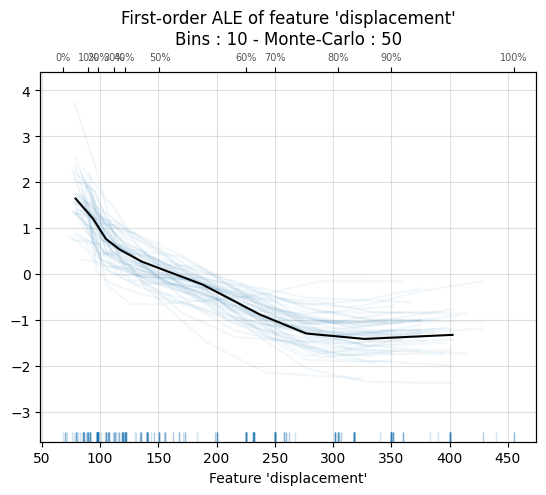

<Axes: title={'center': "First-order ALE of feature 'displacement'\nBins : 10 - Monte-Carlo : 50"}, xlabel="Feature 'displacement'">

In [ ]:
PartialDependenceDisplay.from_estimator(model, X_test, [features[1]], kind='individual', centered=True)
PartialDependenceDisplay.from_estimator(model, X_test, features=[features[1]], kind='both')
ale_plot(model, X_train, features[1], monte_carlo=True)

For the ICE plot, there is a general trend of decreasing MPG with increasing displacement, but some of the individual lines show variability.Since there is high co-relation between the input features, there is a good chance that we have some "impossible" data instances being formed which is giving rise to variations.

The PDP shows a minor decrease in MPG as engine displacement increases from 100 to 200 and then it more or less saturates suggesting there is no further dependence. However, the expectation is that larger engines consume more fuel, so ideally it shouldn't saturate.

The ALE plot shows a more nuanced relationship, with a significant drop in MPG at lower displacement values and a leveling off at higher values. This can basically be interpreted as diminishing returns on the negative impact of displacement as it increases.

Both plots indicate a negative effect of increased displacement on MPG, but the ALE plot provides additional insights into non-linear effects.

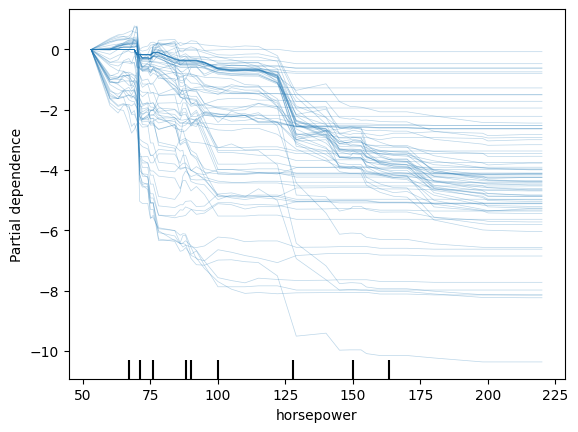

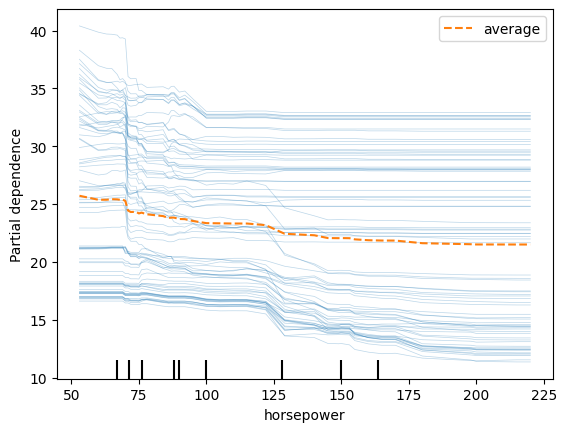

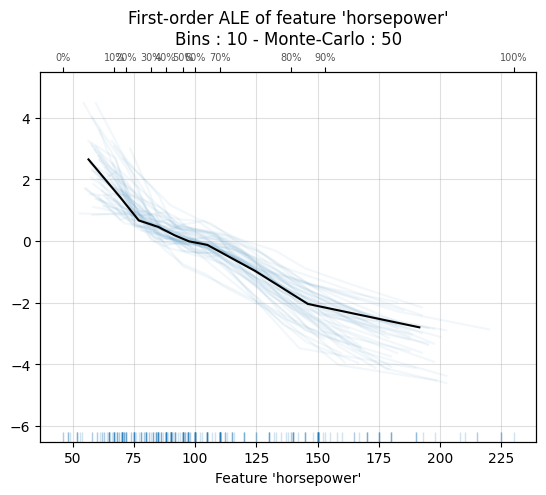

<Axes: title={'center': "First-order ALE of feature 'horsepower'\nBins : 10 - Monte-Carlo : 50"}, xlabel="Feature 'horsepower'">

In [ ]:
PartialDependenceDisplay.from_estimator(model, X_test, [features[2]], kind='individual', centered=True)
PartialDependenceDisplay.from_estimator(model, X_test, features=[features[2]], kind='both')
ale_plot(model, X_train, features[2], monte_carlo=True)

ICE and PDP demonstrates a gradual consistent decline in MPG as horsepower increases. ICE as expected does show variability which is most probably dure to feature co-lations.

The ALE plot shows a similar trend but highlights sharper declines at lower horsepower levels, suggesting that initial increases in horsepower have a more substantial impact on fuel efficiency.

Both plots agree on the overall trend, but the ALE plot provides more detail on how the impact varies across different horsepower levels.

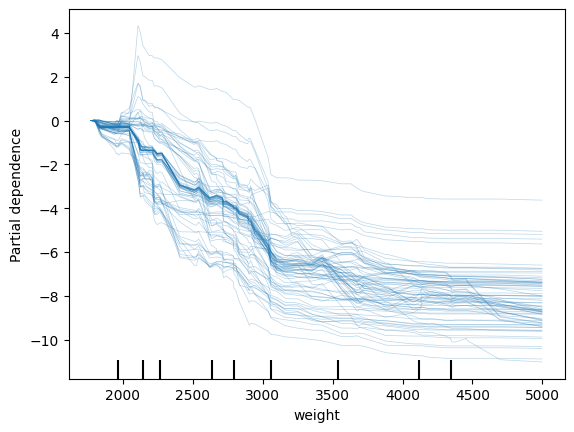

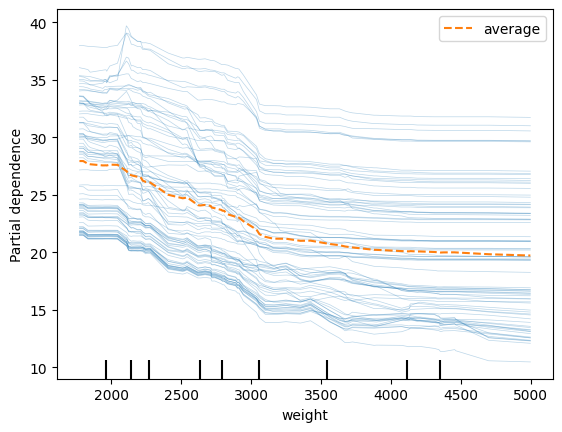

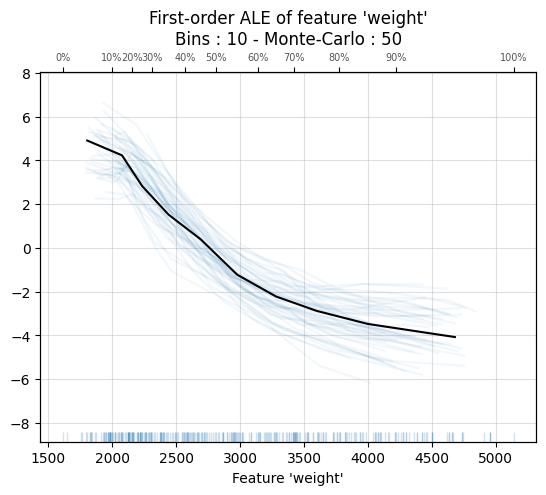

<Axes: title={'center': "First-order ALE of feature 'weight'\nBins : 10 - Monte-Carlo : 50"}, xlabel="Feature 'weight'">

In [ ]:
PartialDependenceDisplay.from_estimator(model, X_test, [features[3]], kind='individual', centered=True)
PartialDependenceDisplay.from_estimator(model, X_test, features=[features[3]], kind='both')
ale_plot(model, X_train, features[3], monte_carlo=True)

All three plots show that increased automobile weight negatively affects MPG.

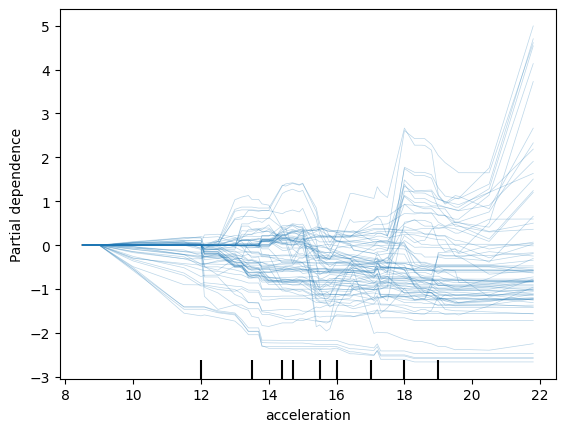

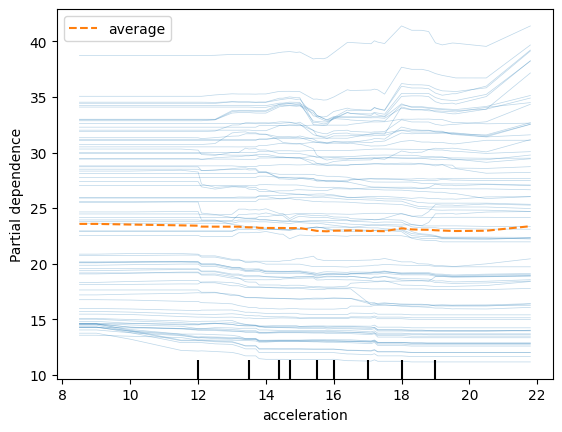

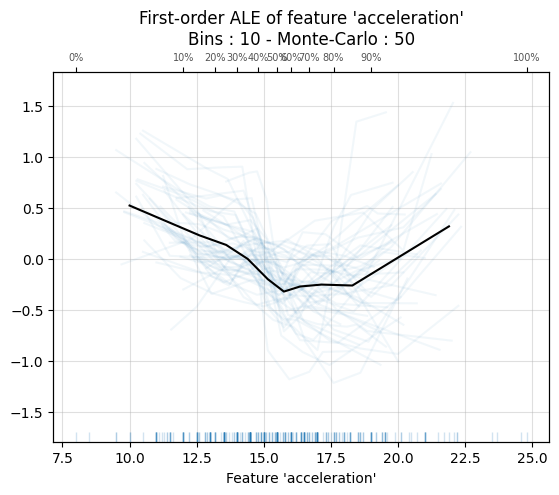

<Axes: title={'center': "First-order ALE of feature 'acceleration'\nBins : 10 - Monte-Carlo : 50"}, xlabel="Feature 'acceleration'">

In [ ]:
PartialDependenceDisplay.from_estimator(model, X_test, [features[4]], kind='individual', centered=True)
PartialDependenceDisplay.from_estimator(model, X_test, features=[features[4]], kind='both')
ale_plot(model, X_train, features[4], monte_carlo=True)

ICE shows high variability, ups and downs as well some instances increasing while other decreasing for the same acceleration values.  

PDP shows a relatively flat trend, indicating that changes in acceleration have a minimal or no impact on MPG. This suggests that acceleration alone does not significantly influence fuel efficiency in the dataset.

However, ALE plot is a U-shaped relationship, with MPG decreasing slightly at mid-range acceleration values and increasing at higher values. This indicates that vehicles with very low or high acceleration might be more fuel-efficient than those with moderate acceleration.

However, both trends seem to not agree with what I would expect based on how fuel efficiency of these cars work in real life. Vehicles with higher acceleration often have more powerful engines, which can lead to lower fuel efficiency. So, the U-shaped pattern in the ALE plot most probably indicates interactions with other features which are affecting fuel efficiency in unexpected ways.

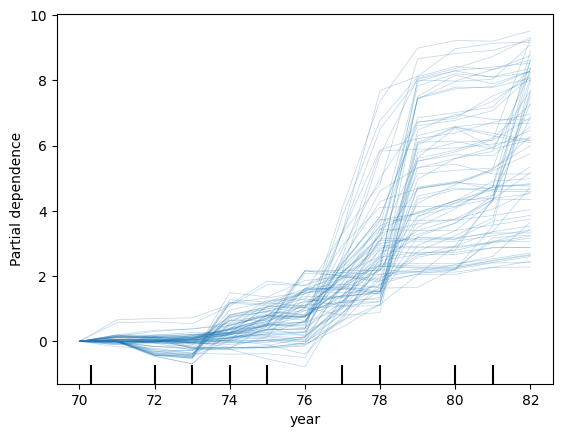

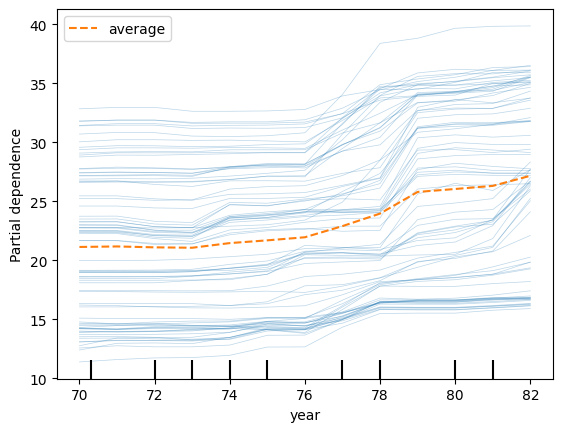

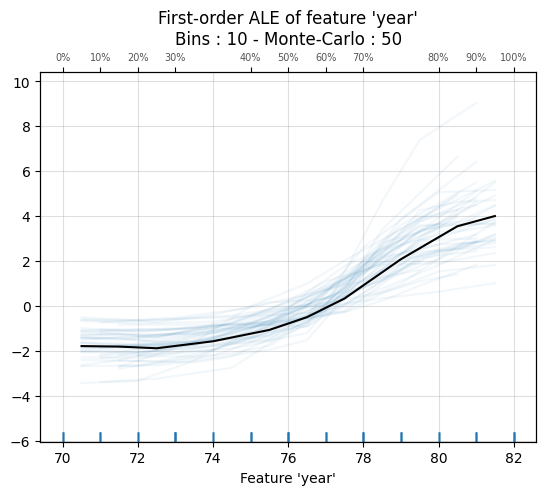

<Axes: title={'center': "First-order ALE of feature 'year'\nBins : 10 - Monte-Carlo : 50"}, xlabel="Feature 'year'">

In [ ]:
PartialDependenceDisplay.from_estimator(model, X_test, [features[5]], kind='individual', centered=True)
PartialDependenceDisplay.from_estimator(model, X_test, features=[features[5]], kind='both')
ale_plot(model, X_train, features[5], monte_carlo=True)

ICE/PDP shows an upward trend, indicating that newer vehicles tend to have higher MPG. This aligns with advancements in automotive technology and stricter fuel efficiency standards over time.

ALE confirms this trend, showing a consistent increase in MPG as the model year progresses. The increase is more pronounced in later years, reflecting
faset technological improvements which makes sense.

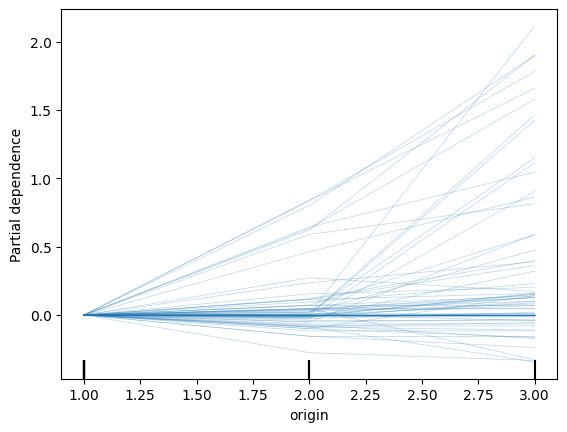

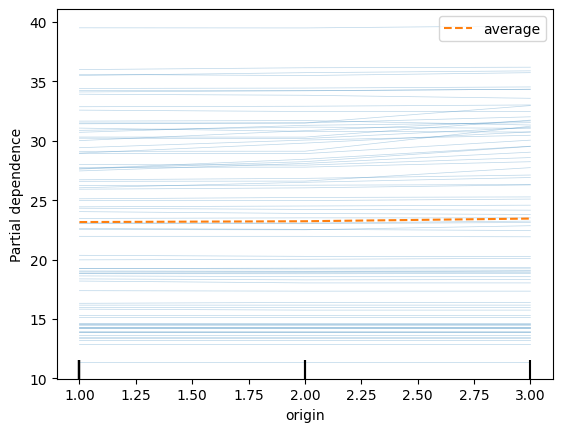

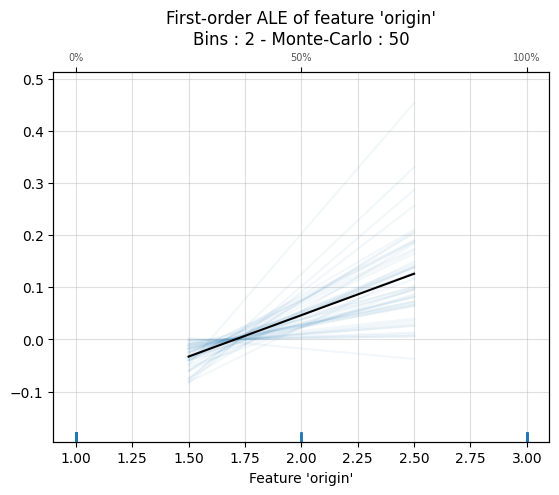

<Axes: title={'center': "First-order ALE of feature 'origin'\nBins : 2 - Monte-Carlo : 50"}, xlabel="Feature 'origin'">

In [ ]:
PartialDependenceDisplay.from_estimator(model, X_test, [features[6]], kind='individual', centered=True)
PartialDependenceDisplay.from_estimator(model, X_test, features=[features[6]], kind='both')
ale_plot(model, X_train, features[6], monte_carlo=True)

PDP shows minimal variation in MPG suggesting that the origin of a vehicle has a limited direct impact on fuel efficiency since ICE plot has instances showing positive as well as negative trends for various instances.

ALE, However shows slight increase in MPG from origin 1 to 3, indicating that vehicles from certain regions might be marginally more fuel-efficient.

# Understanding Second Order ALE PLots

Since the acceleration plot above showed unexpected behaviour with the target variable MPG, we will use second order ALE plots to understand its interaction with other features.

The second-order ALE plots will help understand how acceleration is interacting with other features like horsepower, displacement, weight, and cylinders to affect mpg since they are co-related features.

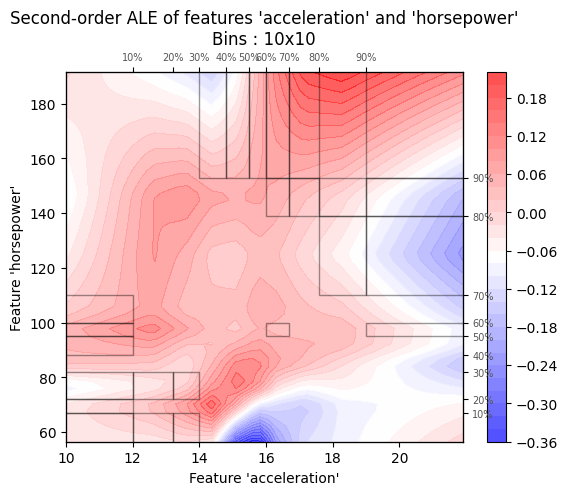

<Axes: title={'center': "Second-order ALE of features 'acceleration' and 'horsepower'\nBins : 10x10"}, xlabel="Feature 'acceleration'", ylabel="Feature 'horsepower'">

In [ ]:
ale_plot(model, X_train, ['acceleration', 'horsepower'], bins=10)

The plot shows that average (14-18) acceleration combined with low horsepower results in lower MPG (blue areas), while slower acceleration with higher horsepower increases MPG (red areas).

Interpretation: Vehicles with high horsepower tend to consume more fuel, especially when accelerating quickly. So low horsepower with decent acceleration rates are fuel efficient. However, higher horsepower and slower acceleration in increasing MPG which should not be the case. Thus for these values, understanding the interactions between the above two features may not be enough since they are further co-related with other features.

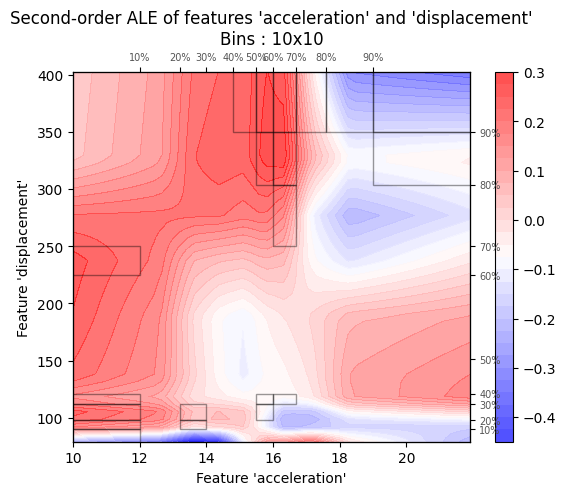

<Axes: title={'center': "Second-order ALE of features 'acceleration' and 'displacement'\nBins : 10x10"}, xlabel="Feature 'acceleration'", ylabel="Feature 'displacement'">

In [ ]:
ale_plot(model, X_train, ['acceleration', 'displacement'], bins=10)

Slower acceleration times with lower or higher displacement boosts mpg, while faster acceleration times with higher displacement reduces MPG.

Interpretation here could be that Larger engines with higher displacement generally consume more fuel. Slower acceleration (greater accleration time on the above plot) helps reduce this effect, improving efficiency.

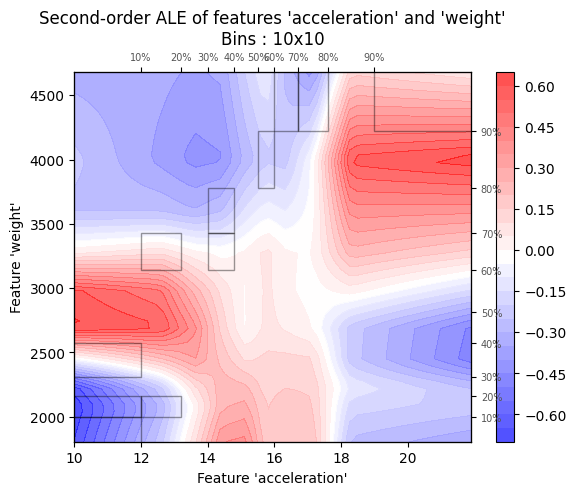

<Axes: title={'center': "Second-order ALE of features 'acceleration' and 'weight'\nBins : 10x10"}, xlabel="Feature 'acceleration'", ylabel="Feature 'weight'">

In [ ]:
ale_plot(model, X_train, ['acceleration', 'weight'], bins=10)

From the ALE plot, lower acceleration time values resulted in a decrease in the MPG value for lesser and high weights whereas for average weighted vehicles, the same acceleration increased MPG.

For higher values of acceleration time, a lower weight resulted in lowering mpg but a higher wight and high acceleration time increases mpg. This again does not make complete sense on its own and there are most probably other features interactions to explain the results better.

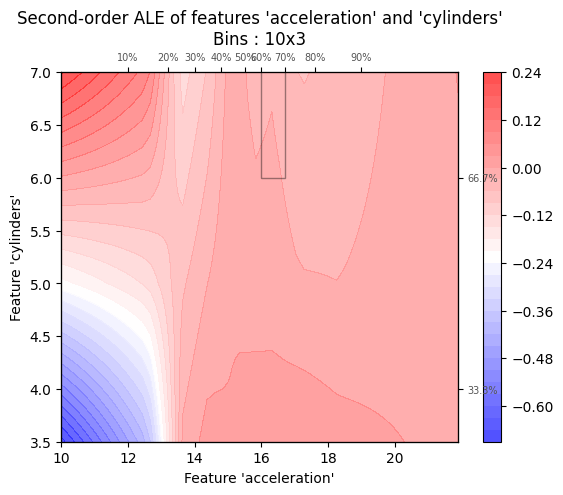

<Axes: title={'center': "Second-order ALE of features 'acceleration' and 'cylinders'\nBins : 10x3"}, xlabel="Feature 'acceleration'", ylabel="Feature 'cylinders'">

In [ ]:
ale_plot(model, X_train, ['acceleration', 'cylinders'], bins=10)


Based on all the 4 interation plots above we can conclude

1. the reason for efficiency increasing when between acc of 15-25 (as per the U-shaped 1st order ALE plot) is most probably because with increase in acceleration time from 15-25 secs, there is also a subsequent higher number of cylinders (5-7) and weight is ranging between 3500-4500 whereas horsepower and displacement values are around 100 and 200 respectively (which are on the lower end). Thus, because of how acceleration is interacting with other features to predict the target variable MPG, we are probably seeing the U-curve above when mpg is plotted against interaction alone in the 1st order ALE plot.